In [533]:
%matplotlib inline
import pandas as pd
import sklearn
import numpy as np
from IPython.display import display
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from sklearn.metrics import f1_score
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from pythainlp.word_vector import sentence_vectorizer

In [2]:
data = pd.read_csv('../../data/the_standard_data_with_features.csv')

In [373]:
data = pd.concat([pd.read_csv('../../data/Ch3_with_features.csv'),
                  pd.read_csv('../../data/ch3_with_features_2.csv')])

/home/arintrongs2/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [374]:
len(data)

45269

## Prepare Data

44258


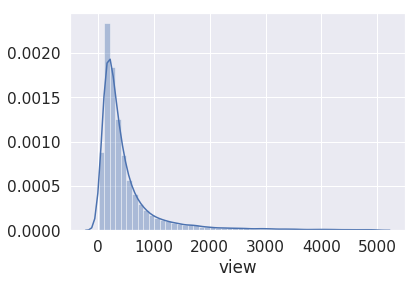

In [375]:
out = data[data['view']<5000]['view']
sns.distplot(out)
print(len(out))

In [376]:
boundary = 10000000
data_bounded = data[data['view']<boundary]
x = data_bounded['view']
std = np.std(x)
mean = np.mean(x)
groups = [0,161,268,384,525,1369,4778,24006,196995,boundary]
print('STD : ',std)
print('MEAN : ',mean)
print(groups)

STD :  3441.6844046949827
MEAN :  825.0044622147607
[0, 161, 268, 384, 525, 1369, 4778, 24006, 196995, 10000000]


In [377]:
pop_level = []
for i in data['view']:
    for j in range(len(groups)-1):
        if i >= groups[j] and i <= groups[j+1]:
            pop_level+=[j]
            continue

In [378]:
print(np.unique(pop_level,return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([ 9754, 10105,  7217,  5366,  8670,  3351,   961,   117,     2]))


<b>Numerical Features</b>

In [379]:
numerical_feature = [
       'numTag', 'numToken', 'numChar','timeDelta', 'num_noun', 'num_pronoun', 'num_verb',
       'num_preverb', 'num_determiner', 'num_adverb', 'num_classifier',
       'num_conjunction', 'num_preposition', 'num_interjunction', 'num_prefix',
       'num_ending', 'num_negator', 'num_punctuation',
       'nnoun_per_ntoken', 'nverb_per_ntoken', 'nadverb_per_ntoken',
       'num_date', 'num_email', 'num_law', 'num_len', 'num_location',
       'num_money', 'num_organization', 'num_percent', 'num_person',
       'num_phone', 'num_time', 'num_url', 'num_person_2', 'num_pos',
       'num_neg', 'sim_top', 'sim_worst', 'tag_pop_sum',
       'tag_pop_mean', 'tag_top_pop_sum', 'tag_top_pop_mean', 'num_tag_pop',
       'tag_top_worst_sum', 'tag_top_worst_mean', 'num_tag_worst']

In [380]:
numerical_feature_data = data[numerical_feature]

In [381]:
numerical_feature_data = numerical_feature_data.values

In [382]:
numerical_feature_data.shape

(45269, 46)

<b>Categorical Features</b>

In [383]:
categorical_feature = [i for i in data.columns if 'is_' in i]

In [384]:
categorical_feature_data = data[categorical_feature].values

In [385]:
categorical_feature_data.shape

(45269, 11)

<b>Title Tokenized Features</b>

In [386]:
title_tokenized = data['token'].apply(lambda x : x.split(','))

In [387]:
word_count = dict()
for headline in title_tokenized:
    for word in headline:
        if word not in word_count:
            word_count[word]=1
        else:
            word_count[word]+=1

In [388]:
word_to_idx = dict()
idx = 2
for key,val in word_count.items():
    if(val > 10):
        word_to_idx[key] = idx
        idx+=1
    else:
        word_to_idx['UNK'] = 1


In [389]:
idx_to_word = {v: k for k, v in word_to_idx.items()}

In [325]:
title_tokenized_features_data = title_tokenized.apply(lambda x : [word_to_idx[i] if i in word_to_idx else word_to_idx['UNK'] for i in x ])
title_tokenized_features_data = title_tokenized_features_data.values

In [326]:
title_tokenized_features_data = pad_sequences(title_tokenized_features_data)

In [327]:
title_tokenized_features_data.shape

(45269, 26)

<b>Pre-Trained Embedded</b>

In [451]:
pre_trained_weights = []
for i in range(1,len(idx_to_word)):
    weight = sentence_vectorizer(idx_to_word[i])
    pre_trained_weights+=[weight]

In [452]:
pre_trained_weights = np.asarray(pre_trained_weights)

In [461]:
pre_trained_weights = pre_trained_weights.reshape((3636,300))

<b>NER</b>

In [328]:
from pythainlp.tag.named_entity import ThaiNameTagger
from pythainlp.tag import pos_tag

In [329]:
ner_tagger = ThaiNameTagger()

In [330]:
headlines = data['token']
headlines = headlines.apply(lambda x : x.split(','))
headlines = [[ner_tagger.get_ner(i)[0] for i in tokens] for tokens in headlines]

In [332]:
ner = set()
pos = set()
for hl in headlines:
    for word in hl:
        ner.add(word[1])
        pos.add(word[2])

In [333]:
ner = list(ner)
pos = list(pos)
ner_idx = [i for i in range(1,len(ner)+1)]
pos_idx = [i for i in range(1,len(pos)+1)]

In [334]:
ner_to_idx = dict(zip(ner,ner_idx))
idx_to_ner = {v: k for k, v in ner_to_idx.items()}

pos_to_idx = dict(zip(pos,pos_idx))
idx_to_pos = {v: k for k, v in pos_to_idx.items()}

In [335]:
data_ner = headlines
x = []
for idx in range(len(data_ner)):
    temp = []
    for word in data_ner[idx]:
        temp+=[ner_to_idx[word[1]]]
        temp+=[pos_to_idx[word[2]]]
    x+=[temp]
x = np.asarray(x)

In [336]:
ner_features = pad_sequences(x)

In [337]:
ner_features.shape

(45269, 52)

Prepare Y

In [338]:
def prepare_y(data):
    y = []
    for i in data:
        c = 0
        for j in range(len(groups)-1):
            if i >= groups[j] and i <= groups[j+1]:
                y+=[j]
                c=1
                break
        if c==0:
            y+=[0]
        
    return y

In [339]:
y_train = prepare_y(np.asarray(data['view']))
y_train = to_categorical(y_train)

In [340]:
y_train.shape

(45269, 9)

## Model

In [341]:
from keras.models import Model, Input
from keras.layers import Dense, Dropout, BatchNormalization, GRU, Conv1D, Dropout, Embedding, concatenate, Flatten
from keras.optimizers import Adam

In [342]:
def get_categorical_model_part(category_count,input_shape):
    input1 = Input(shape=(input_shape,))
    x = Embedding(category_count,32)(input1)
    x = Flatten()(x)
    x = Dense(256,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    return input1, x    

In [343]:
def get_numerical_model_part(features_len,input_shape):
    input1 = Input(shape=(input_shape,))
    x = Dense(256,activation='relu')(input1)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    return input1, x

In [464]:
def get_title_embedding_part(word_count,input_shape):
    input1 = Input(shape=(input_shape,))
    x = Embedding(word_count-1,300,trainable=True,weights=[pre_trained_weights])(input1)
    x = Flatten()(x)
    x = Dense(256,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    return input1, x

In [465]:
def get_keyword_embedding_part(keyword_count,input_shape):
    input1 = Input(shape=(input_shape,))
    x = Embedding(keyword_count,32)(input1)
    x = Flatten()(x)
    x = Dense(256,activation='relu')(x)
    x = Dropout(0.5)(x)
    
    return input1, x

In [466]:
def get_ner_part(input_shape):
    input1 = Input(shape=(input_shape,))
    x = Dense(256,activation='relu')(input1)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128,activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    return input1, x

In [467]:
def get_model():
    input1, m1 = get_categorical_model_part(categorical_feature_data.shape[1],categorical_feature_data.shape[1])
    input2, m2 = get_numerical_model_part(numerical_feature_data.shape[1],numerical_feature_data.shape[1])
    input3, m3 = get_title_embedding_part(len(word_to_idx),title_tokenized_features_data.shape[1])
    input4, m4 = get_ner_part(ner_features.shape[1])
    x = concatenate([m1,m2,m3,m4])
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(y_train.shape[1],activation='softmax')(x)
    model = Model(inputs=[input1,input2,input3,input4], outputs=x)
    adam  = Adam(lr=0.0001)
    model.compile(optimizer=adam,  loss='categorical_crossentropy' ,metrics=['accuracy'])
    
    return model
    

In [468]:
model = get_model()

In [469]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           (None, 11)           0                                            
__________________________________________________________________________________________________
input_58 (InputLayer)           (None, 26)           0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 11, 32)       352         input_56[0][0]                   
__________________________________________________________________________________________________
embedding_33 (Embedding)        (None, 26, 300)      1090800     input_58[0][0]                   
__________________________________________________________________________________________________
flatten_25

In [470]:
train_data = [categorical_feature_data,numerical_feature_data,title_tokenized_features_data,ner_features]
train_x = []
temp_train_x = []
test_x = []
val_x = []
for data in train_data:
    train, test = train_test_split(data, test_size=0.1,random_state=22)
    temp_train_x += [train]
    test_x += [test]
for data in temp_train_x:
    train, val = train_test_split(data, test_size=0.1,random_state=22)
    train_x += [train]
    val_x += [val]
temp_train_y, test_y = train_test_split(y_train, test_size=0.1,random_state=22)
train_y, val_y = train_test_split(temp_train_y, test_size=0.1,random_state=22)


In [479]:
model.fit(train_x, train_y, batch_size=64 ,epochs=10, verbose=1, validation_data=[val_x, val_y])

Train on 36667 samples, validate on 4075 samples
Epoch 1/10
36667/36667 [==============================] - 18s 482us/step - loss: 1.7353 - acc: 0.3103 - val_loss: 1.7250 - val_acc: 0.3021
Epoch 2/10
36667/36667 [==============================] - 18s 483us/step - loss: 1.7023 - acc: 0.3306 - val_loss: 1.7125 - val_acc: 0.3060
Epoch 3/10
36667/36667 [==============================] - 18s 482us/step - loss: 1.6553 - acc: 0.3454 - val_loss: 1.6985 - val_acc: 0.3063
Epoch 4/10
36667/36667 [==============================] - 18s 483us/step - loss: 1.5970 - acc: 0.3724 - val_loss: 1.6926 - val_acc: 0.3134
Epoch 5/10
36667/36667 [==============================] - 18s 482us/step - loss: 1.5442 - acc: 0.4012 - val_loss: 1.6980 - val_acc: 0.3055
Epoch 6/10
36667/36667 [==============================] - 18s 483us/step - loss: 1.4873 - acc: 0.4280 - val_loss: 1.7083 - val_acc: 0.3090
Epoch 7/10
36667/36667 [==============================] - 18s 482us/step - loss: 1.4290 - acc: 0.4523 - val_loss: 1.7

KeyboardInterrupt: 

In [496]:
y_pred = model.predict(test_x)

In [497]:
def evaluate(y_pred,y_test):
    correct = 0
    wrong = 0
    count = [0,0,0,0,0,0,0,0,0]
    heatmap =[[0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0],
             [0,0,0,0,0,0,0,0,0]]
    true_pred = [0]*7
    for i in range(len(y_pred)):
        p_level_pred = np.argmax(y_pred[i])
        p_level_test = np.argmax(y_test[i])
        count[p_level_pred]+=1
        heatmap[p_level_test][p_level_pred]+=1
        if(p_level_pred == p_level_test):
            true_pred[p_level_pred] += 1
            correct += 1
        else:
            wrong +=1
    print(np.asarray(heatmap))
    heatmap = [[line[i]/np.sum(line) for i in range(len(line))] for line in heatmap]
    print(count)
    return correct/(correct+wrong), heatmap

In [498]:
score, heatmap = evaluate(y_pred,test_y)
print(score)
# print(heatmap)

[[481 253  66   3 107   9   0   0   0]
 [245 441  93  17 224   5   1   0   0]
 [125 265  80  10 241   5   0   0   0]
 [ 83 206  50  10 183   1   0   0   0]
 [136 265 105  20 357  22   2   0   0]
 [ 52  79  23   7 114  28  22   0   0]
 [  5   9   4   2  14  29  16   0   0]
 [  0   3   0   0   2   6   1   0   0]
 [  0   0   0   0   0   0   0   0   0]]
[1127, 1521, 421, 69, 1242, 105, 42, 0, 0]
0.3121272365805169


/home/arintrongs2/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars


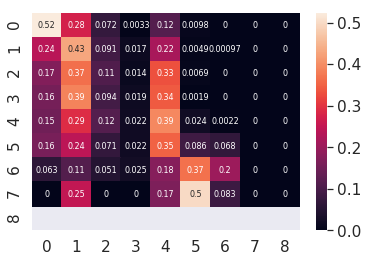

In [499]:
df_cm = pd.DataFrame(heatmap, range(9),
                  range(9))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 8})

In [534]:
def evaluate_f1(y_pred, y_test):
    acc = 0
    pred = list()
    true = list()
    for i in range(len(y_pred)):
        pred.append(np.argmax(y_pred[i]))
        true.append(np.argmax(y_test[i]))
    return f1_score(true, pred, average='micro'),pred,true

In [535]:
score, pred, true = evaluate_f1(y_pred,test_y)

In [538]:
print(score)

0.3121272365805169


In [537]:
test_y.shape

(4527, 9)

NameError: name 'input_pbs_train' is not defined

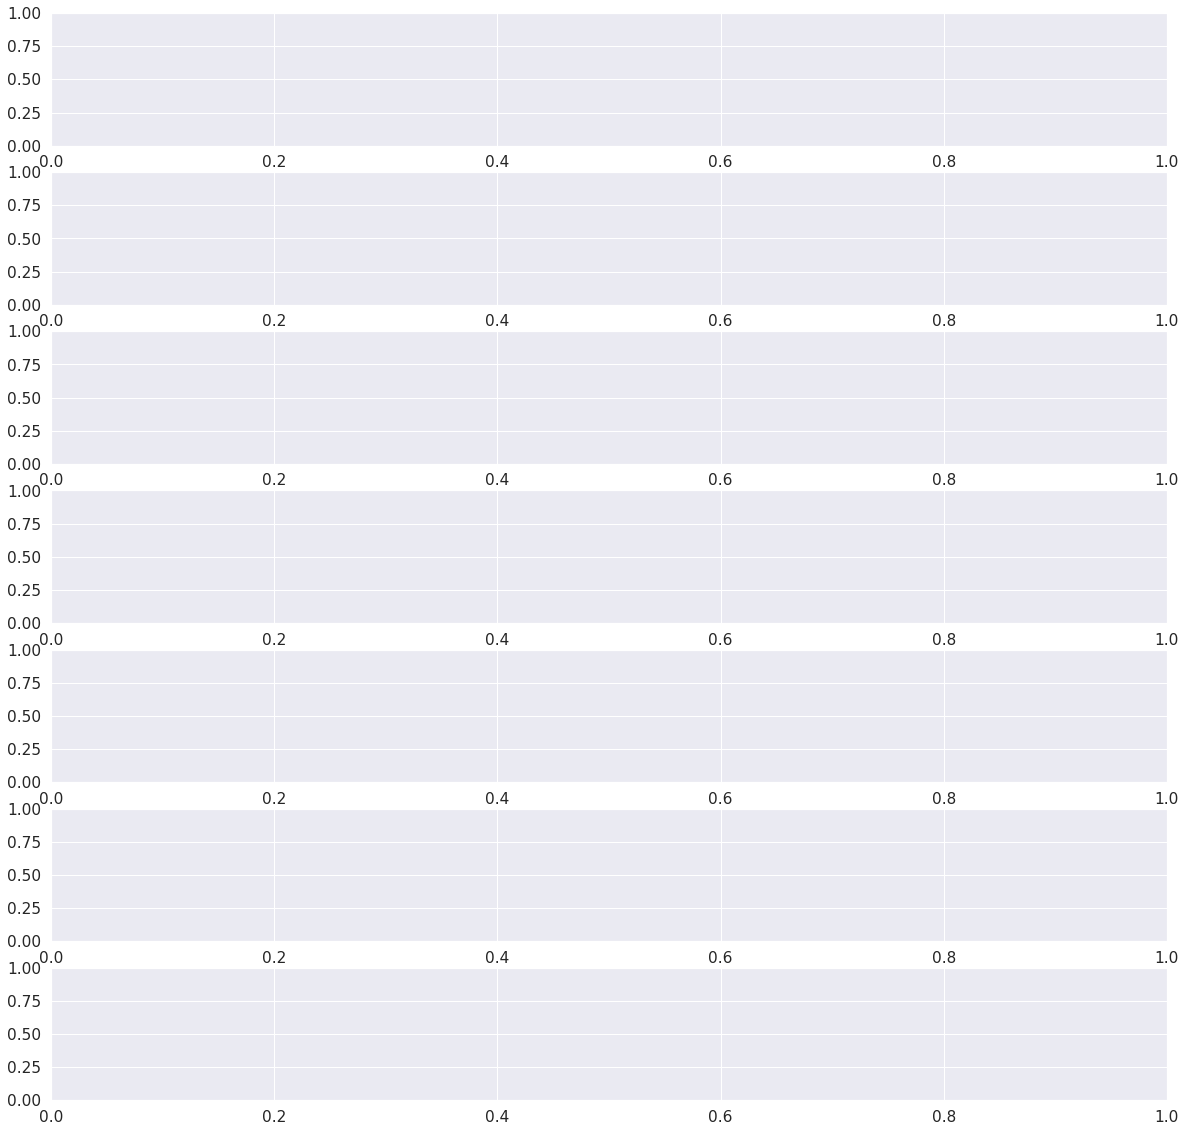

In [539]:
f, axarr = plt.subplots(7, figsize=(20,20))
for i in range(7):
#     print(i,len(input_pbs_train[input_pbs_train['class']==i]))
    if len(input_pbs_train[input_pbs_train['class']==i]) > 1:
        sns.distplot(input_pbs_train[input_pbs_train['class']==i]['view'],ax=axarr[i],bins=50)